In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#read csv file
df = pd.read_csv('INPUT-DATA.csv')


df

,Ionic radius,Temperature,Frequency,Re(Z),Img(Z)
0,1.820000e-10,-10,1000000.00,3160.0,9670.0
1,1.820000e-10,-10,926000.00,3480.0,10200.0
2,1.820000e-10,-10,858000.00,3840.0,10300.0
3,1.820000e-10,-10,794000.00,4210.0,10600.0
4,1.820000e-10,-10,736000.00,4530.0,10900.0
...,...,...,...,...,...
4643,2.060000e-10,80,1.45,68600.0,10900.0
4644,2.060000e-10,80,1.32,69400.0,11300.0
4645,2.060000e-10,80,1.20,70300.0,11700.0
4646,2.060000e-10,80,1.10,71200.0,12100.0


In [34]:
#store data in df50 where the value of temperature is 50
df50 = df[df['Temperature'] == 50]
df50

,Ionic radius,Temperature,Frequency,Re(Z),Img(Z)
1086,1.820000e-10,50,1000000.00,3920.0,11700.0
1087,1.820000e-10,50,926000.00,4550.0,12500.0
1088,1.820000e-10,50,858000.00,5180.0,13100.0
1089,1.820000e-10,50,794000.00,5640.0,13800.0
1090,1.820000e-10,50,736000.00,6360.0,14500.0
...,...,...,...,...,...
3737,2.060000e-10,50,1.20,85800.0,14200.0
3738,2.060000e-10,50,1.15,86300.0,14200.0
3739,2.060000e-10,50,1.10,86700.0,14500.0
3740,2.060000e-10,50,1.05,87200.0,14600.0


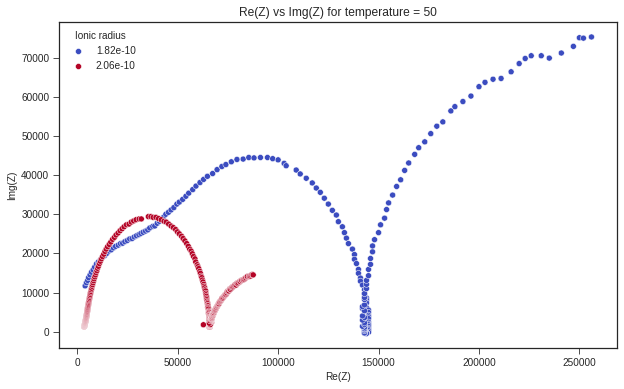

In [35]:
df50 = df[df['Temperature'] == 50]
#plot scatter plot with different colors for 'Ionic radius'
plt.figure(figsize=(10, 6))
plt.title('Re(Z) vs Img(Z) for temperature = 50')
plt.xlabel('Re(Z)')
plt.ylabel('Img(Z)')
sns.scatterplot(x='Re(Z)', y='Img(Z)', data=df50, hue='Ionic radius ', palette='coolwarm')
plt.show()

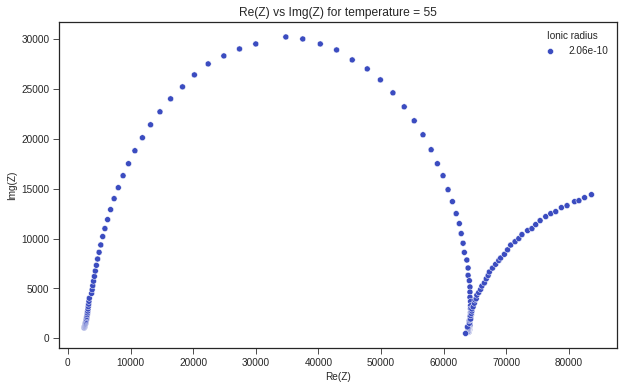

In [32]:
df55 = df[df['Temperature'] == 55]
#plot scatter plot with different colors for 'Ionic radius'
plt.figure(figsize=(10, 6))
plt.title('Re(Z) vs Img(Z) for temperature = 55')
plt.xlabel('Re(Z)')
plt.ylabel('Img(Z)')
sns.scatterplot(x='Re(Z)', y='Img(Z)', data=df55, hue='Ionic radius ', palette='coolwarm')
plt.show()

In [ ]:
# i want to plot nyquist plot for temperature = 50 using this equation  "R_0-p(R_1,CPE_1)-p(R_2,CPE_2)" and I want to predict Re(Z) and Img(Z) on basis of frequency that using xgboost 


/tmp/ipykernel_5110/477600559.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df50['Img(Z)'] = df50['Img(Z)'].abs()


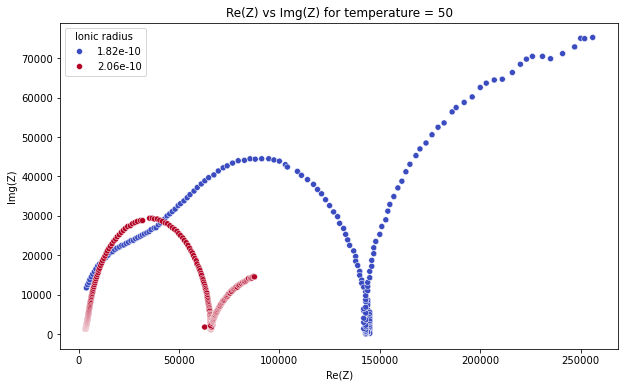

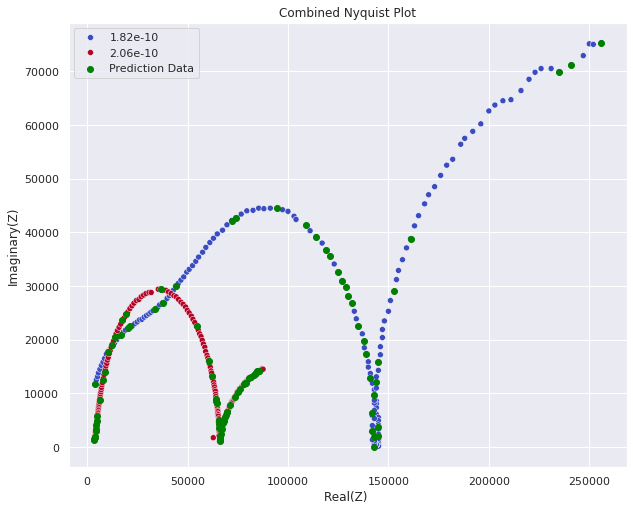

Fitted Parameters: [2.33729677e+04 6.47605744e+04 1.28868045e-08 6.49004950e-01
 2.14053864e+04 2.56841681e-07 8.45628168e-01]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Read the CSV file
df = pd.read_csv('INPUT-DATA.csv')
df50 = df[df['Temperature'] == 50]

# Ensure Img(Z) is positive
df50['Img(Z)'] = df50['Img(Z)'].abs()

# Plot scatter plot with different colors for 'Ionic radius'
plt.figure(figsize=(10, 6))
plt.title('Re(Z) vs Img(Z) for temperature = 50')
plt.xlabel('Re(Z)')
plt.ylabel('Img(Z)')
sns.scatterplot(x='Re(Z)', y='Img(Z)', data=df50, hue='Ionic radius ', palette='coolwarm')
plt.show()

# Function to clean data (removing NaNs and Infs)
def clean_data(frequencies, Z):
    mask = ~np.isnan(Z) & ~np.isinf(Z)
    return frequencies[mask], Z[mask]

# Extract frequency and impedance data
frequencies, Z = df50['Frequency'].values, (df50['Re(Z)'] + 1j * df50['Img(Z)']).values
frequencies, Z = clean_data(frequencies, Z)

# Define the circuit model
circuit_str = 'R_0-p(R_1,CPE_1)-p(R_2,CPE_2)'
initial_guess = [4.08127359e+01,  5.10336218e+04, 1.33749422e-09, 7.20182283e-01, 0.95110848e+04, 1.37210091e-06, 9.20690396e-01]
# initial_guess = [2.33729677e+04, 6.47605744e+04, 1.28868045, 6.49004950, 2.14053864e+04, 2.56841681e-07, 8.45628168e-01]

circuit = CustomCircuit(circuit=circuit_str, initial_guess=initial_guess)
circuit.fit(frequencies, Z)
Z_fit = circuit.predict(frequencies)

# Train XGBoost models for Re(Z) and Img(Z) prediction
X = frequencies.reshape(-1, 1)
y = df50[['Re(Z)', 'Img(Z)']]
# y_re = df50['Re(Z)']
# y_img = df50['Img(Z)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(X, y_re, test_size=0.2, random_state=42)
# X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(X, y_img, test_size=0.2, random_state=42)


#Train XGBoost models
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)



# # Define XGBoost models

# model_re = xgb.XGBRegressor()
# model_img = xgb.XGBRegressor()

# model_re.fit(X_train_re, y_train_re)
# model_img.fit(X_train_img, y_train_img)

# y_pred_re = model_re.predict(X_test_re)
# y_pred_img = model_img.predict(X_test_img)

# # Calculate mean squared errors
# mse_re = mean_squared_error(y_test_re, y_pred_re)
# mse_img = mean_squared_error(y_test_img, y_pred_img)

# print(f'Mean Squared Error for Re(Z): {mse_re}')
# print(f'Mean Squared Error for Img(Z): {mse_img}')

# Combine both graphs in one
plt.figure(figsize=(10, 18))

sns.set()

# Plot experimental data scatter plot
plt.subplot(2, 1, 1)
plt.title('Re(Z) vs Img(Z) for temperature = 50')
plt.xlabel('Re(Z)')
plt.ylabel('Img(Z)')
sns.scatterplot(x='Re(Z)', y='Img(Z)', data=df50, hue='Ionic radius ', palette='coolwarm')

# Plot fitted model
# plot_nyquist(Z_fit, fmt='', scale=10, ax=plt.gca(), label='Fitted Model')


# Nyquist Plot XGBoost predictions 


# Plot XGBoost predictions
plt.legend()
plt.title('XGBoost Predictions')
plt.xlabel('Re(Z)')
plt.ylabel('Img(Z)')
plt.scatter(y_test['Re(Z)'], y_test['Img(Z)'], c='green', label='Prediction Data', alpha=1)
# # plt.scatte ='XGBoost Predictions', alpha=0.9)

plt.legend()
plt.title('Combined Nyquist Plot')
plt.xlabel('Real(Z) ')
plt.ylabel('Imaginary(Z)')
plt.grid(True)
plt.show()

print("Fitted Parameters:", circuit.parameters_)



/home/kushal/.local/lib/python3.10/site-packages/impedance/visualization.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)
/home/kushal/.local/lib/python3.10/site-packages/impedance/visualization.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)
/home/kushal/.local/lib/python3.10/site-packages/impedance/visualization.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)
/home/kushal/.local/lib/python3.10/site-packages/impedance/visualization.py:39: UserWarning: marker is redundant

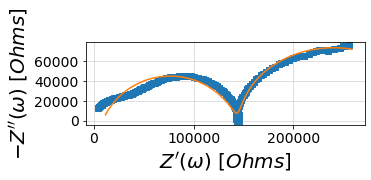


Circuit string: R_0-p(CPE_1,R_1)-p(CPE_2,R_2-p(L_3,R_3))
Fit: True

Initial guesses:
    R_0 = 5.82e+01 [Ohm]
  CPE_1_0 = 6.86e-10 [Ohm^-1 sec^a]
  CPE_1_1 = 7.51e-01 []
    R_1 = 1.18e+03 [Ohm]
  CPE_2_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE_2_1 = 4.29e-01 []
    R_2 = 2.29e+05 [Ohm]
    L_3 = 4.34e+01 [H]
    R_3 = 1.23e+05 [Ohm]

Fit parameters:
    R_0 = 8.96e+03  (+/- 4.33e+02) [Ohm]
  CPE_1_0 = 1.46e-09  (+/- 1.69e-10) [Ohm^-1 sec^a]
  CPE_1_1 = 7.42e-01  (+/- 1.67e-03) []
    R_1 = 1.35e+05  (+/- 2.79e+02) [Ohm]
  CPE_2_0 = 1.04e-06  (+/- 5.85e-08) [Ohm^-1 sec^a]
  CPE_2_1 = 8.17e-01  (+/- 1.04e-02) []
    R_2 = 1.98e+05  (+/- 1.42e+02) [Ohm]
    L_3 = 3.54e+03  (+/- 1.02e+03) [H]
    R_3 = 1.24e+06  (+/- 1.65e-01) [Ohm]



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
from scipy.optimize import minimize

# Load the data
data = pd.read_csv(r"50(1).csv")

# Extract frequencies, real and imaginary parts of impedance
frequencies = data.iloc[:, 0].values
real_Z = data.iloc[:, 1].values
imag_Z = data.iloc[:, 2].values

# Combine real and imaginary parts into a complex array
Z = real_Z + 1j * imag_Z

# Ignore data below a certain threshold (if applicable)
#frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)

# Check if the data is empty
if len(Z) == 0:
    raise ValueError("Impedance data Z is empty after preprocessing!")

# Define the function to fit and plot the circuit
def fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str):
    customCircuit = CustomCircuit(initial_guess=initial_guess, circuit=circuit_str)
    customCircuit.fit(frequencies, Z)
    customCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
    plt.show()
    print(customCircuit)
    return customCircuit

# Objective function for optimization
def objective_function(params, frequencies, Z, circuit_str):
    customCircuit = CustomCircuit(initial_guess=params, circuit=circuit_str)
    customCircuit.fit(frequencies, Z)
    residuals = np.abs(customCircuit.predict(frequencies) - Z)
    return np.sum(residuals ** 2)

# Initial guess for the circuit parameters
initial_guess = [5.90383086e+01, 6.83438971e-10, 7.53300859e-01, 1.13807139e+03, 9.97690033e-06, 4.26260989e-01, 2.30213997e+05, 4.28394116e+01, 1.22365084e+05]

# Circuit string
circuit_str = 'R_0 - p(CPE_1,R_1) - p(CPE_2,R_2 - p(L_3, R_3))'

# Iteratively optimize the circuit parameters until fitting is satisfactory
tolerance = 1e-6  # Define a fitting tolerance
previous_fit_error = np.inf
max_iterations = 1
iteration = 0

while iteration < max_iterations:
    result = minimize(objective_function, initial_guess, args=(frequencies, Z, circuit_str), method='Nelder-Mead')
    customCircuit = CustomCircuit(initial_guess=result.x, circuit=circuit_str)
    customCircuit.fit(frequencies, Z)
    fit_error = objective_function(result.x, frequencies, Z, circuit_str)
    
    # Check if the improvement is within the tolerance
    if abs(previous_fit_error - fit_error) < tolerance:
        break
    
    previous_fit_error = fit_error
    iteration += 1
    initial_guess = result.x  # Update initial guess for next iteration

# Fit and plot the optimized circuit
fit_and_plot_circuit(frequencies, Z, result.x, circuit_str)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
from scipy.optimize import minimize
import seaborn as sns

# Load and process the input data
df = pd.read_csv('INPUT-DATA.csv')

# Filter and drop specific columns
df = df[df['Ionic radius '] != 2.060000e-10]
df = df.drop(columns=['Ionic radius '])
df = df[df['Temperature'] == 60]
df = df.drop(columns=['Temperature'])
df = df.drop(df.index[0])
df = df.reset_index(drop=True)

# Rename columns and adjust values
df.rename(columns={'Frequency': 'frequency'}, inplace=True)
df['Img(Z)'] = df['Img(Z)'] * -1
df.to_csv('60(1).csv', index=False)

# Load the data for fitting
frequencies, Z = preprocessing.readCSV('60(1).csv')
frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)

# Remove NaN values
mask = ~np.isnan(Z)
frequencies, Z = frequencies[mask], Z[mask]

# Check the content of frequencies and Z
print(f"frequencies: {frequencies}")
print(f"Z: {Z}")
print(f"Shape of frequencies: {frequencies.shape}")
print(f"Shape of Z: {Z.shape}")

# Define the function to fit and plot the circuit
def fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str):
    customCircuit = CustomCircuit(initial_guess=initial_guess, circuit=circuit_str)
    customCircuit.fit(frequencies, Z)
    customCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
    plt.show()
    print(customCircuit)
    return customCircuit

# Objective function for optimization
def objective_function(params, frequencies, Z, circuit_str):
    customCircuit = CustomCircuit(initial_guess=params, circuit=circuit_str)
    customCircuit.fit(frequencies, Z)
    residuals = np.abs(customCircuit.predict(frequencies) - Z)
    return np.sum(residuals ** 2)

# Initial guess for the circuit parameters
initial_guess = [5.90383086e+01, 6.83438971e-10, 7.53300859e-01, 1.13807139e+03, 9.97690033e-06, 4.26260989e-01, 2.30213997e+05, 4.28394116e+01, 1.22365084e+05]

# Circuit string
circuit_str = 'R_0 - p(CPE_1,R_1) - p(CPE_2,R_2 - p(L_3, R_3))'

# Iteratively optimize the circuit parameters until fitting is satisfactory
tolerance = 1e-6  # Define a fitting tolerance
previous_fit_error = np.inf
max_iterations = 1  # Define maximum iterations for optimization
iteration = 0

while iteration < max_iterations:
    result = minimize(objective_function, initial_guess, args=(frequencies, Z, circuit_str), method='Nelder-Mead')
    customCircuit = CustomCircuit(initial_guess=result.x, circuit=circuit_str)
    customCircuit.fit(frequencies, Z)
    fit_error = objective_function(result.x, frequencies, Z, circuit_str)
    
    # Check if the improvement is within the tolerance
    if abs(previous_fit_error - fit_error) < tolerance:
        break
    
    previous_fit_error = fit_error
    iteration += 1
    initial_guess = result.x  # Update initial guess for next iteration

# Fit and plot the optimized circuit
fit_and_plot_circuit(frequencies, Z, result.x, circuit_str)

# Extract fitted values for plotting
Z_fit = customCircuit.predict(frequencies)

# Convert Z and Z_fit to a DataFrame
Z_df = pd.DataFrame({'Re(Z)': np.real(Z), 'Img(Z)': -np.imag(Z)})
Z_fit_df = pd.DataFrame({'Re(Z)_fit': np.real(Z_fit), 'Img(Z)_fit': -np.imag(Z_fit)})

# Save the DataFrames to CSV
Z_df.to_csv('Z.csv', index=False)
Z_fit_df.to_csv('Z_fit.csv', index=False)

# Load data for plotting
plot_data = pd.read_csv('Z.csv')
plot_data_fit = pd.read_csv('Z_fit.csv')

# Verify column names and inspect data
print(plot_data_fit.head())

# Adjust the plotting code to convert data to numpy arrays
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Re(Z)', y='Img(Z)', data=plot_data, label='Data', color='blue')
sns.scatterplot(x=plot_data_fit['Re(Z)_fit'].values, y=plot_data_fit['Img(Z)_fit'].values, label='Fit', color='red')
plt.xlabel('Re(Z) [Ohm]')
plt.ylabel('-Imag(Z) [Ohm]')
plt.title('Nyquist Plot')
plt.legend()
plt.show()

print('Circuit Type', 1)
print(customCircuit)


frequencies: [9.26e+05 8.58e+05 7.94e+05 7.36e+05 6.81e+05 6.31e+05 5.84e+05 5.41e+05
 5.01e+05 4.64e+05 4.30e+05 3.98e+05 3.69e+05 3.41e+05 3.16e+05 2.93e+05
 2.71e+05 2.51e+05 2.33e+05 2.15e+05 2.00e+05 1.85e+05 1.71e+05 1.58e+05
 1.47e+05 1.36e+05 1.26e+05 1.17e+05 1.08e+05 1.00e+05 9.26e+04 8.58e+04
 7.94e+04 7.36e+04 6.81e+04 6.31e+04 5.84e+04 5.41e+04 5.01e+04 4.64e+04
 4.30e+04 3.98e+04 3.69e+04 3.41e+04 3.16e+04 2.93e+04 2.71e+04 2.51e+04
 2.33e+04 2.15e+04 1.99e+04 1.85e+04 1.71e+04 1.58e+04 1.47e+04 1.36e+04
 1.26e+04 1.17e+04 1.08e+04 1.00e+04 9.26e+03 8.57e+03 7.94e+03 7.35e+03
 6.81e+03 6.31e+03 5.84e+03 5.41e+03 5.01e+03 4.64e+03 4.30e+03 3.98e+03
 3.69e+03 3.42e+03 3.16e+03 2.93e+03 2.71e+03 2.51e+03 2.33e+03 2.15e+03
 2.00e+03 1.85e+03 1.71e+03 1.58e+03 1.47e+03 1.36e+03 1.26e+03 1.17e+03
 1.08e+03 1.00e+03 9.26e+02 8.58e+02 7.94e+02 7.36e+02 6.81e+02 6.31e+02
 5.84e+02 5.41e+02 5.01e+02 4.64e+02 4.30e+02 3.98e+02 3.69e+02 3.41e+02
 3.16e+02 2.93e+02 2.71e+02 2.51e+02 2

KeyboardInterrupt: 